In [1]:
import tensorflow_datasets as tfds

2022-03-31 11:04:17.502331: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-31 11:04:17.502420: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Dataset interessanti: `arithmetic__add_sub_multiple`, `arithmetic__mixed`, `arithmetic__simplify_surd` (problemi che includono espressioni complesse).

Su `arithmetic__mixed`, ad esempio, secondo il [paper originale](https://arxiv.org/pdf/1904.01557v1.pdf) un Transformer semplice arriva circa al 70% di accuratezza in test di interpolazione e 20% in test di estrapolazione.

NOTA: le note a margine delle celle sono state prese considerando questo dataset. Le analisi si possono eseguire anche usando altri dataset come input, ma le considerazioni a margine *potrebbero* non essere più valide.

Plot dal paper:

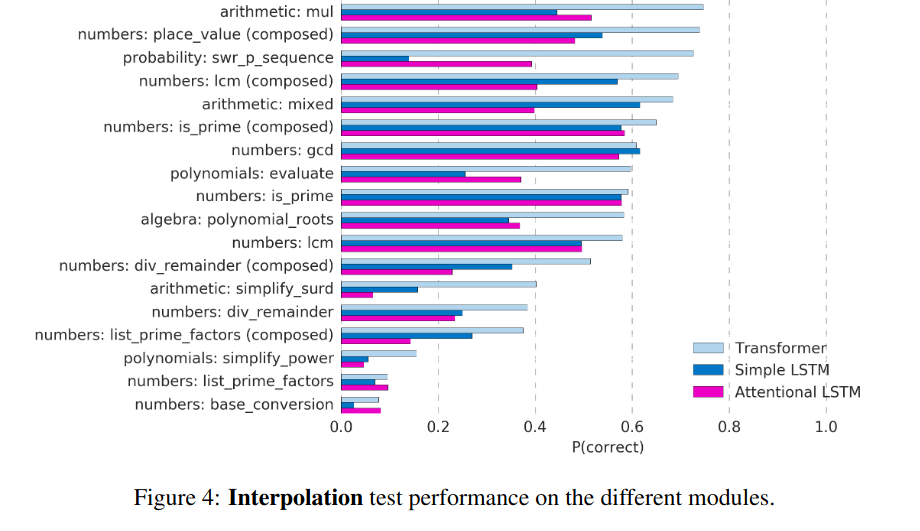
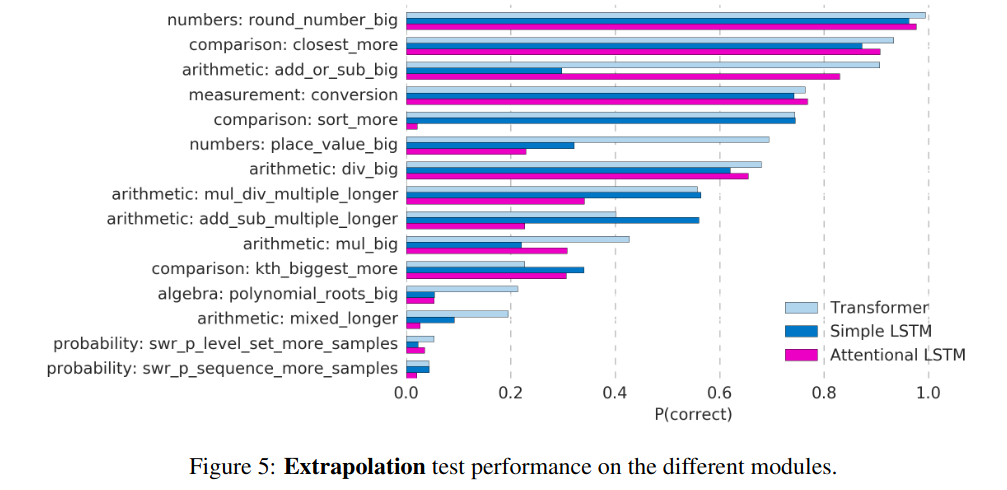

In [2]:
%%capture
ds = tfds.load(f'math_dataset/arithmetic__mixed', split=['train'], as_supervised=True, batch_size=-1)

2022-03-31 11:05:00.896803: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-31 11:05:00.896857: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (labsrv7): /proc/driver/nvidia/version does not exist
2022-03-31 11:05:00.937478: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


In [3]:
ds = tfds.as_numpy(ds)

In [4]:
samples = ds[0][0]
targets = ds[0][1]

In [5]:
import pandas as pd

In [6]:
samples_s = pd.Series(samples)
samples_s = samples_s.apply(lambda x: x.decode())

In [7]:
targets_s = pd.Series(targets)
targets_s = targets_s.apply(lambda x: x.decode())

## Alcuni esempi

In [8]:
samples_s.head(25)

0                       What is 2392/414 + (1 - 7 - 0)?
1              What is the value of 42/756 + 127/(-18)?
2                            Evaluate -43 + 22*819/693.
3                      What is 180*((-465)/(-60) + -8)?
4                         Evaluate (-57)/11 - 16/(-88).
5             What is the value of 6/(-9)*5685/(-7201)?
6     What is the value of 2/(-118) + (-2887410)/140...
7                What is the value of 5/14*(-54)/(-45)?
8                 Calculate 5/((-440)/(-16) + (2 - 7)).
9                        ((-3)/(-9))/(9531/(-432) + 22)
10         Calculate ((-43498)/18642)/(2/(3/(-6) - 1)).
11    Evaluate ((-5116)/(-70345))/(334/(-70) + 63/(-...
12                       Evaluate (-2)/3 + (-224)/96*1.
13                     Calculate 7/((-21)/15)*(2 + -3).
14                            ((-4)/(-36))/(40/(-1170))
15                     (266/1862)/((1/21)/((-7)/(-21)))
16    Calculate (-23)/((-828)/(-198)) - ((-36)/6 + -3).
17         What is the value of 6/45*15*(45 - -2

Non tutti gli esempi finiscono con lo stesso carattere (ad es. `?`) quindi va usato un `EOS`.

Le frazioni che coinvolgono numeri negativi hanno sempre parentesi intorno a questi numeri: $-m/-n$ è sempre scritto come `(-m)/(-n)`.

In [9]:
targets_s.head(25)

0       -2/9
1         -7
2        -17
3        -45
4         -5
5      10/19
6       -2/9
7        3/7
8        2/9
9      -16/3
10       7/4
11    -2/143
12        -3
13         5
14     -13/4
15         1
16       7/2
17        70
18      1/13
19        -4
20       -13
21     -2/19
22        52
23      2/13
24       -73
dtype: object

La risposta alla prima domanda è:

In [10]:
2394/414 - 6

-0.21739130434782616

Il risultato segnato come corretto è:

In [11]:
-2/9

-0.2222222222222222

In [12]:
42/756 - 127/18

-7.0

I risultati sono sempre scritti in forma frazionaria e possono non essere esatti.

Le espressioni sono difficili o praticamente impossibili da valutare in pochi passi di computazione anche per una persona. Serve sicuramente carta e penna e, soprattutto per moltiplicazioni e divisioni o operazioni con grandi operandi, servono molti passi di calcolo, che deve comunque usare una procedura di calcolo appresa in precedenza.

Sicuramente una rete neurale può apprendere una approssimazione delle quattro operazioni per operandi di lunghezza arbitraria. C'è evidenza che tutte le quattro operazioni di per sé possono essere modellate quasi senza errore: somme e sottrazioni sono lineari, moltiplicazioni e divisioni sono somme e sottrazioni in spazio logaritmico, quindi una rete può apprendere internamente una rappresentazione diversa dell'operando e poi fare la stessa operazione in tutti i casi. 

Il processo di valutazione delle operazioni aritmetiche è quindi sicuramente diverso per una rete neurale e per una persona. Quello che si potrebbe chiedere è se problemi più complessi che coinvolgono parentesi vengono risolti da un modello a memoria esterna facendo step di computazione intermedi. In principio, per una operazione come `180*((-465)/(-60) + -8)` sarebbe possibile valutare il valore degli operandi intermedi come fatto nel caso semplice senza parentesi, scriverlo in memoria e poi valutare il valore dell'espressione complessiva.

## Numero di esempi

In [13]:
from humanfriendly import format_number

In [14]:
format_number(len(samples))

'1,999,998'

## Distribuzione delle lunghezze

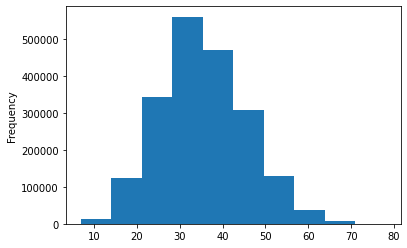

In [15]:
sample_lengths = samples_s.str.len()
_ = sample_lengths.plot.hist()

## Numero di parentesi in ogni domanda

Tutte le espressioni sono ben formate?

In [16]:
num_left_brackets = samples_s.str.count(r'\(')
num_right_brackets = samples_s.str.count(r'\)')
(num_left_brackets == num_right_brackets).all()

True

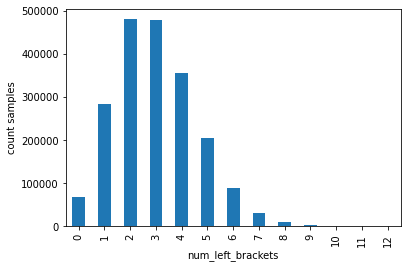

In [17]:
_ = num_left_brackets.value_counts().sort_index().plot.bar(xlabel='num_left_brackets', ylabel='count samples')

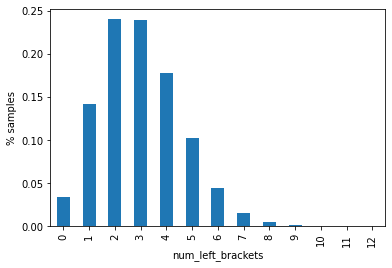

In [18]:
perc_n_brackets = num_left_brackets.value_counts() / len(samples)
_ = perc_n_brackets.sort_index().plot.bar(xlabel='num_left_brackets', ylabel='% samples')

In [19]:
perc_n_brackets.sort_index().loc[4:].sum()

0.34606734606734607

Circa il 34% degli esempi ha più di 4 parentesi, quindi una complessità algoritmica più elevata (nel senso che sono necessari più step di computazione per risolvere il problema). Questa è all'incirca la percentuale di errori del Transformer su questo problema, per cui è possibile che la maggiore complessità delle domande in questo senso ne sia la causa.

## Numero di operandi in ogni domanda

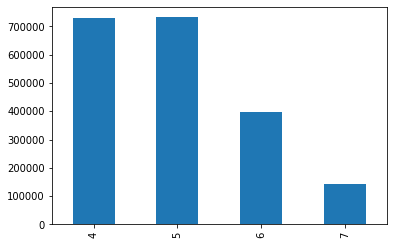

In [20]:
num_operands = samples_s.str.count(r'[\d]+')
__ = num_operands.value_counts().sort_index().plot.bar()

## Numero di operatori in ogni domanda

Per operatori intendiamo `+ - * /`, considerando che - è anche un operatore unario che cambia il segno di un operando.

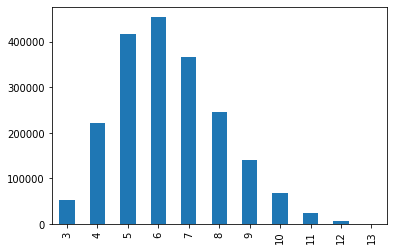

In [21]:
num_operators = samples_s.str.count(r'[+\-*/]+')
_ = num_operators.value_counts().sort_index().plot.bar()

Tutti questi grafici ci danno la stessa informazione sulla complessità delle domande. C'è una ovvia correlazione tra il numero di parentesi, operandi, operatori e lunghezza delle domande.

## Le domande come testo

In [22]:
from sklearn.feature_extraction import text as skt

In [24]:
word_count_vectorizer = skt.CountVectorizer()
word_count_vectorizer = word_count_vectorizer.fit(samples_s)
len(word_count_vectorizer.vocabulary_)

145523

In [25]:
word_count_vectorizer.vocabulary_

{'what': 145522,
 'is': 145518,
 '2392': 55320,
 '414': 89763,
 'the': 145520,
 'value': 145521,
 'of': 145519,
 '42': 90694,
 '756': 127789,
 '127': 15166,
 '18': 37256,
 'evaluate': 145517,
 '43': 92190,
 '22': 50054,
 '819': 132819,
 '693': 122212,
 '180': 37257,
 '465': 97065,
 '60': 113188,
 '57': 109936,
 '11': 6106,
 '16': 29842,
 '88': 137398,
 '5685': 109776,
 '7201': 124647,
 '118': 10530,
 '2887410': 67036,
 '14066190': 21617,
 '14': 21316,
 '54': 106581,
 '45': 95034,
 'calculate': 145516,
 '440': 93628,
 '9531': 142465,
 '432': 92466,
 '43498': 92921,
 '18642': 39443,
 '5116': 103127,
 '70345': 123163,
 '334': 76165,
 '70': 122847,
 '63': 116230,
 '147': 24444,
 '224': 51174,
 '96': 142922,
 '21': 47163,
 '15': 25697,
 '36': 80962,
 '40': 87567,
 '1170': 10019,
 '266': 61910,
 '1862': 39367,
 '23': 52846,
 '828': 133515,
 '198': 43371,
 '12': 11586,
 '13': 16676,
 '396': 86928,
 '90': 138859,
 '25': 58045,
 '938': 141466,
 '6365': 116862,
 '110': 6107,
 '154': 27370,
 '258

In [26]:
char_count_vectorizer = skt.CountVectorizer(analyzer='char')
char_count_vectorizer = char_count_vectorizer.fit(samples_s)
len(char_count_vectorizer.vocabulary_)

32

In [27]:
char_count_vectorizer.vocabulary_.keys()

dict_keys(['w', 'h', 'a', 't', ' ', 'i', 's', '2', '3', '9', '/', '4', '1', '+', '(', '-', '7', '0', ')', '?', 'e', 'v', 'l', 'u', 'o', 'f', '5', '6', '8', '*', '.', 'c'])

Nota: l'attributo `vocabulary_` [contiene](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) "A mapping of terms to feature indices.".

Nelle domande ci sono $145523$ parole e solo $32$ caratteri, chiaramente perché le parole sono per lo più numeri che hanno molta variabilità. Nel `word_vectorizer` le espressioni sono semplificate, cioè gli simboli sono rimossi dal tokenizer.